In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np

from sklearn import datasets
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split, StratifiedKFold

K_FOLD_SPLITS = 4

covertype_datasets = datasets.fetch_covtype()
# 1 index になっているので 0-index に直す
covertype_datasets.target -= 1

n_features = len(covertype_datasets.feature_names)
print("n_features", n_features)
n_classes = len(np.unique(covertype_datasets.target))


n_features 54


c:\Users\Yoshinari\Documents\GitHub\University\knowledge_acquisition_systems\.venv\lib\site-packages\sklearn\mixture\_base.py:282: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  ConvergenceWarning,


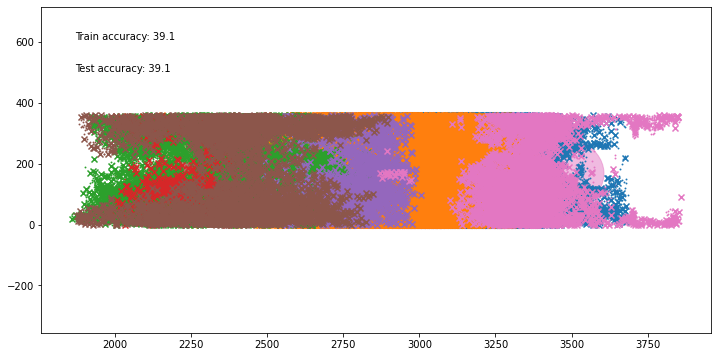

In [2]:
colors = ["C" + str(i) for i in range(n_classes)]

plt.figure(figsize=(12, 6))

skf = StratifiedKFold(n_splits=K_FOLD_SPLITS, shuffle=True)

train_accuracy_array = np.zeros(K_FOLD_SPLITS)
test_accuracy_array = np.zeros(K_FOLD_SPLITS)

estimator = GaussianMixture(
    n_components=n_classes, covariance_type="tied", max_iter=20, random_state=0
)

def make_ellipses(gmm, ax):
    for n, color in enumerate(colors):
        if gmm.covariance_type == "full":
            covariances = gmm.covariances_[n][:2, :2]
        elif gmm.covariance_type == "tied":
            covariances = gmm.covariances_[:2, :2]
        elif gmm.covariance_type == "diag":
            covariances = np.diag(gmm.covariances_[n][:2])
        elif gmm.covariance_type == "spherical":
            covariances = (
                np.eye(gmm.means_.shape[1]) * gmm.covariances_[n]
            )  # means_ のサイズは (n_classes, n_features)
        v, w = np.linalg.eigh(covariances)
        u = w[0] / np.linalg.norm(w[0])
        angle = np.rad2deg(np.arctan2(u[1], u[0]))
        v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
        ell = mpl.patches.Ellipse(
            gmm.means_[n, :2], v[0], v[1], 180 + angle, color=color
        )
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)
        ax.set_aspect("equal", "datalim")

for times, (train_index, test_index) in enumerate(
    skf.split(covertype_datasets.data, covertype_datasets.target)
):
    X_train, X_test = (
        covertype_datasets.data[train_index],
        covertype_datasets.data[test_index],
    )
    y_train, y_test = (
        covertype_datasets.target[train_index],
        covertype_datasets.target[test_index],
    )

    estimator.means_init = np.array(
        [X_train[y_train == i].mean(axis=0) for i in range(n_classes)]
    )

    estimator.fit(X_train)

    y_train_pred = estimator.predict(X_train)
    train_accuracy = np.mean(y_train_pred.ravel() == y_train.ravel()) * 100
    train_accuracy_array[times] = train_accuracy

    y_test_pred = estimator.predict(X_test)
    test_accuracy = np.mean(y_test_pred.ravel() == y_test.ravel()) * 100
    test_accuracy_array[times] = test_accuracy

train_accuracy = train_accuracy_array.mean()
test_accuracy = test_accuracy_array.mean()

X_train, X_test, y_train, y_test = train_test_split(
    covertype_datasets.data, covertype_datasets.target, test_size=1 / K_FOLD_SPLITS
)

estimator.means_init = np.array(
    [X_train[y_train == i].mean(axis=0) for i in range(n_classes)]
)

estimator.fit(X_train)

h = plt.subplot(1, 1, 1)
make_ellipses(estimator, h)

for n, color in enumerate(colors):
    data = covertype_datasets.data[covertype_datasets.target == n]
    plt.scatter(
        data[:, 0],
        data[:, 1],
        s=0.8,
        color=color
    )

for n, color in enumerate(colors):
    data = X_test[y_test == n]
    plt.scatter(data[:, 0], data[:, 1], marker="x", color=color)


plt.text(0.05, 0.9, "Train accuracy: %.1f" % train_accuracy, transform=h.transAxes)
plt.text(0.05, 0.8, "Test accuracy: %.1f" % test_accuracy, transform=h.transAxes)

plt.show()


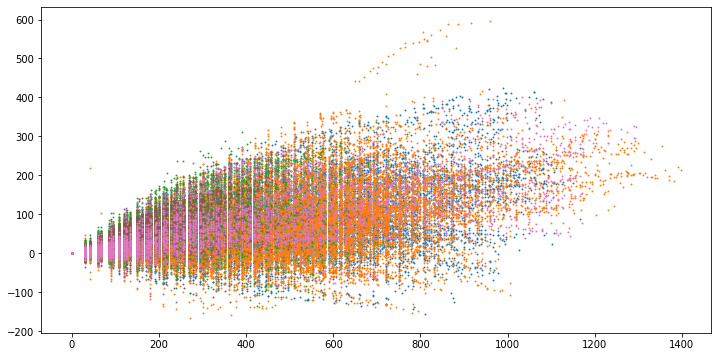

In [3]:
plt.figure(figsize=(12, 6))

for n, color in enumerate(colors):
    data = X_test[y_test == n]
    plt.scatter(data[:, 3], data[:, 4], color=color, s=0.8)
